# Purpose

* To simplify the interpolation table 
* use the frequency independent analytical part instead of rescaling
* to test speed wrt to prototype04_bns_unequal_mass_snr_interpolator

I will use the `FINDCHIRP` algorithm.  SNRsqured will be given by

$(\rho)^2 = \mathcal{A}^2_{FreqIndependent} \int_{f_{min}}^{f_{max}} \frac{f^{-7/3}}{S_n(f)} \,df$

* interpolation will be done only for $\int_{f_{min}}^{f_{max}} \frac{f^{-7/3}}{S_n(f)} \,df$ 
* $\mathcal{A}$ is a simple analytical function. Numpy array operation can be use. There will not be any for loop or if-else statement involved
* if numpy operation is not speedy enough, $\mathcal{A}$ calculation can be done in C code and link to this notebook with cython code

# without interpolation

* there will be min for $dM_{tot}$. So the length of $M_{tot}$ array will only have $\frac{M^{max}_{tot}-M^{min}_{tot}}{dM_{tot}}$ 
* say, $dM_{tot}=0.001M_{\odot}$ and $M^{max}_{tot}-M^{min}_{tot} = 100M_{\odot}$ then there will be $10^5$ elements in the array.
* the function $\int_{f_{min}}^{f_{max}} \frac{f^{-7/3}}{S_n(f)} \,df$ will be stored according to an array of [$M^{min}_{tot}+dM_{tot}$ , $M^{min}_{tot}+2*dM_{tot}$,,,,...] 
* So, when random $M_{tot}$ is given, correspoding index in the array [$M^{min}_{tot}+dM_{tot}$ , $M^{min}_{tot}+2*dM_{tot}$,,,,...] will be found.
* $index = \frac{M_{tot}}{dM_{tot}}-\frac{M^{min}_{tot}}{dM_{tot}}$
* so we can only stored 1D array of the function $\int_{f_{min}}^{f_{max}} \frac{f^{-7/3}}{S_n(f)} \,df$ in the txt file. 
* Thus interpolation is not needed

# To check the interpolation of $\int_{f_{min}}^{f_{max}} \frac{f^{-7/3}}{S_n(f)} \,df$ wrt to $M_{tot}$

* for neutron star case
* information below 20Hz and above 1024Hz is dominated by noise 
* prior mass in detector frame Uniform[1$M_{\odot}$,3$M_{\odot}$] 
* the longest possible signal duration from f_min=20Hz to $\text{f}_{lso}$ is \~310s . It corresponds $m1=m2=1M_{\odot}$

In [1]:
from bilby.core import utils
from pycbc.detector import Detector
import bilby
import numpy as np
import matplotlib.pyplot as plt
from prototype02_cbcsnrs import CBCSNRsBase, compute_bilby_snr
%matplotlib inline

C = 299792458.
G = 6.67408*1e-11
Mo = 1.989*1e30
Mpc = 3.086*1e22

In [3]:
bilby.gw.utils.calculate_time_to_merger(20.,1.,1.)

309.04052540580625

In [2]:
asd = bilby.gw.detector.PowerSpectralDensity(asd_file = 'aLIGO_O4_high_asd.txt')

In [3]:
# single detector 
def integrate(f_min=20.,f_max=1024.,ifo=asd, duration=4):
    df = 1/duration
    f_array = np.arange(f_min,f_max,df)
    noise_array = ifo.get_power_spectral_density_array(f_array)
    
    return(df*f_array**(-7/3)/noise_array)

In [19]:
%timeit integrate(f_min=20.,f_max=1024.,ifo=asd, duration=128.)

2.43 ms ± 64.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
def integrate2(f_min=20.,mtot=20.,ifo=asd):
    #duration = bilby.gw.utils.calculate_time_to_merger(f_min,mtot/2,mtot/2)
    duration = 32.
    df = 1/duration
    f_max = (C**3)/( G*mtot*Mo*np.pi*6**(3/2) )
    f_array = np.arange(f_min,f_max,df)
    noise_array = ifo.get_power_spectral_density_array(f_array)
    
    return( df*np.sum(f_array**(-7/3)/noise_array) )

In [23]:
%timeit integrate2(f_min=20.,mtot=20.,ifo=asd)

271 µs ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [25]:
%timeit integrate2(f_min=20.,mtot=5.,ifo=asd)

1.37 ms ± 25.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [50]:
%timeit integrate2(f_min=20.,mtot=2.,ifo=asd)

1.31 ms ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
mtot_array = np.geomspace(2.,200.,100)
integrate_array = []

for mtot in mtot_array:
    integrate_array.append(integrate2(f_min=20.,mtot=mtot,ifo=asd))

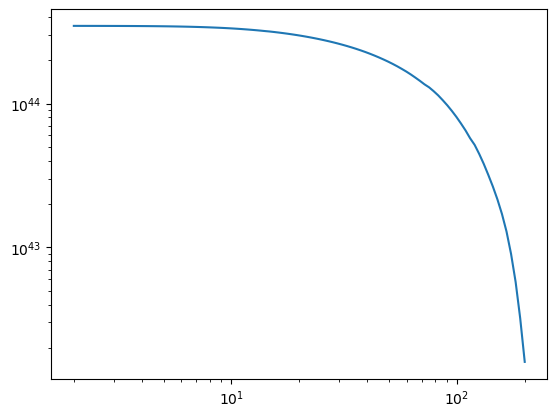

In [10]:
plt.loglog(mtot_array,integrate_array)

In [11]:
from scipy.interpolate import interp1d

In [12]:
x = mtot_array
y = np.array(integrate_array)
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

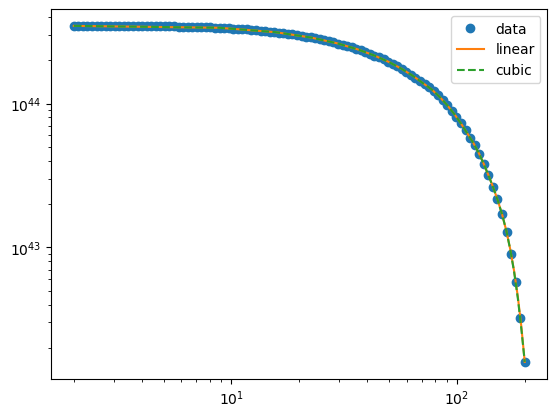

In [15]:
xnew = np.linspace(2, 200, num=30, endpoint=True)

plt.loglog(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

In [16]:
from prototype02_cbcsnrs import CBCSNRsBase, compute_bilby_snr

In [21]:
nn = len(mtot_array)
snr_array = np.zeros(nn)
for idx in range(nn):
    f_min = 20.
    mass_1 = mtot_array[idx]/2.
    mass_2 = mass_1
    luminosity_distance = 3604
    theta_jn = np.pi/10
    duration = bilby.gw.utils.calculate_time_to_merger(f_min, mass_1, mass_2, safety = 1.2 )
    ra, dec, psi, phase, geocent_time = np.pi/5, np.pi/8, np.pi/3, 3*np.pi/5, 182381.12
    a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0
    snr_[idx] = compute_bilby_snr(mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, 
                      luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec, 
                      duration=duration, sampling_frequency=2048, 
                      waveform_arguments= dict(waveform_approximant = "TaylorF2", reference_frequency = 20., minimum_frequency = 20), 
                      list_of_detectors=["L1"])
    

IllegalDurationAndSamplingFrequencyException: 
Your sampling frequency and duration must multiply to a numberup to (tol = 14) decimals close to an integer number. 
But sampling_frequency=2048 and  duration=337.1351186245159 multiply to 690452.7229430085

In [24]:
mass_1 = 12.
mass_2 = mass_1
luminosity_distance = 3604
theta_jn = np.pi/10
ra, dec, psi, phase, geocent_time = np.pi/5, np.pi/8, np.pi/3, 3*np.pi/5, 182381.12
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0
duration = bilby.gw.utils.calculate_time_to_merger(f_min, mass_1, mass_2, safety = 1.2 )

compute_bilby_snr(mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec, duration=duration, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "TaylorF2", reference_frequency = 50., minimum_frequency = 10), list_of_detectors=["L1"])

IllegalDurationAndSamplingFrequencyException: 
Your sampling frequency and duration must multiply to a numberup to (tol = 14) decimals close to an integer number. 
But sampling_frequency=4096 and  duration=5.2240113567643265 multiply to 21397.55051730668

In [27]:
bilby.gw.utils.calculate_time_to_merger(20., 1., 1., safety = 1.2 )

337.1351186245159